We're going to analyze the performance of some competing implementations of e-divisive with means calculators.

Let's start by importing stuff:

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt
from signal_processing_algorithms.e_divisive import EDivisive
from signal_processing_algorithms.e_divisive.base import EDivisiveCalculator
from signal_processing_algorithms.e_divisive.calculators import cext_calculator, numpy_calculator
from signal_processing_algorithms.e_divisive.significance_test import QHatPermutationsSignificanceTester
from signal_processing_algorithms.e_divisive import default_implementation
from collections import OrderedDict

In [2]:
from numpy_calculator import NumpyCalculator
from numpy_windowed_calculator import NumpyWindowedCalculator
from optimized_calculator import OptimizedCalculator
from original_calculator import OriginalCalculator
from windowed_calculator import WindowedCalculator

We're going to be making our e-divisive algorithm in a standard way, only switching out the calculator being used:

In [3]:
def make_e_divisive(calculator):
    tester = QHatPermutationsSignificanceTester(
        calculator=calculator, pvalue=0.05, permutations=100
    )
    return EDivisive(seed=1234, calculator=calculator, significance_tester=tester)

So, we've got the following below:
* Default implemetation provided by this package
* Using the numpy calculator provided by this package
* Using the C extension provided by this package (this is the default implementation, for the record)
* Using a window based calculator
* Using a window based calculator, that leverages numpy
* Using an "optimized" calculator -- updating terms using deltas rather than recalculating them
* The original calculator, using straight python w/o numpy for sums and recalculating terms
* Using numpy for sums

In [4]:
implementations = {
    "default_implementation": default_implementation(),
    "normal": make_e_divisive(numpy_calculator),
    "c_extension": make_e_divisive(cext_calculator), # This is the default implementation, under the covers
    "windowed": make_e_divisive(WindowedCalculator),
    "numpy_windowed": make_e_divisive(NumpyWindowedCalculator),
    "optimized": make_e_divisive(OptimizedCalculator),
    "original": make_e_divisive(OriginalCalculator),
    "numpy": make_e_divisive(NumpyCalculator),
}

Our first test will be generating time series with lengths between 100 and 1000, inclusive, in steps of 10. Each time series will contain 4 mean shifts, and 1 standard deviation worth of noise.

In [27]:
class Results:
    def __init__(self, x, y, name):
        self.x = x
        self.y = y
        self.name = name
        
    def __repr__(self):
        return f"{self.name}-Results({self.x},{self.y})"

def make_test(lengths, num_bkps, noise, implementations):
    test_series = []
    results = []

    for length in lengths:
        signal, bkps = rpt.pw_constant(length, 1, num_bkps, noise_std=noise)
        feed_signal = [x[0] for x in signal]
        test_series.append((signal, feed_signal, bkps))
    for name, implementation in implementations.items():
        lengths = []
        times = []
        for series, feed_signal, bkps in test_series:
            s = time.time()
            implementation.fit_predict(feed_signal)
            e = time.time() - s
            times.append(e)
            lengths.append(len(feed_signal))
        results.append(Results(np.array(lengths), np.array(times), name))
    results = sorted(results, key=lambda x:x.y[-1])
    return results

In [28]:
results = make_test(range(10, 50, 10), 4, 1, implementations)

In [30]:
def plot_results(results, scale_to=None):
    for res in results:
        if scale_to is not None:
            plt.plot(res.x, res.y / scale_to.y, label=res.name)
        else:
            plt.plot(res.x, res.y, label=res.name)
    plt.legend()

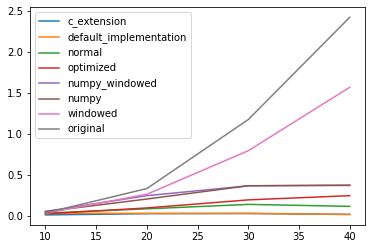

In [31]:
plot_results(results)

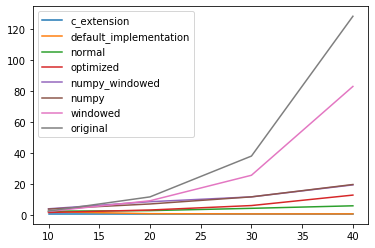

In [32]:
plot_results(results, scale_to=results[0])

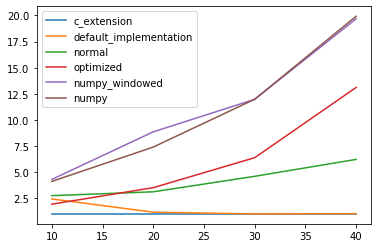

In [33]:
plot_results(results[:-2], scale_to=results[0])

In [34]:
results = make_test(range(100, 210, 10), 4, 1, implementations)

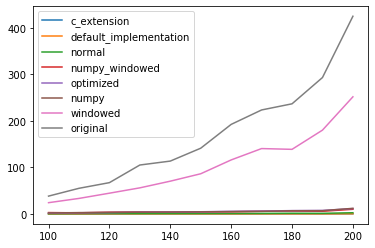

In [35]:
plot_results(results)

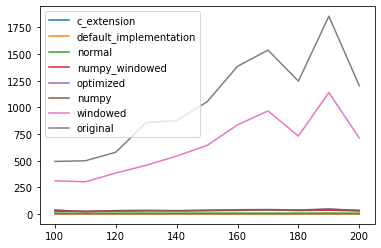

In [36]:
plot_results(results, scale_to=results[0])

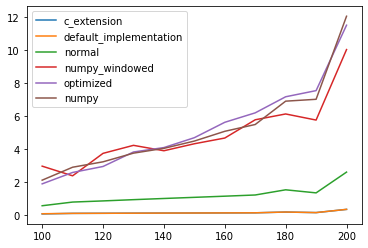

In [37]:
plot_results(results[:-2])

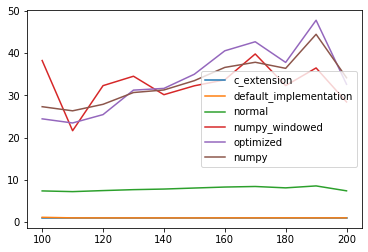

In [38]:
plot_results(results[:-2], scale_to=results[0])

In [39]:
implementations = {
    "normal": make_e_divisive(numpy_calculator),
    "c_extension": make_e_divisive(cext_calculator)
}

In [40]:
results = make_test(range(100, 310, 10), 4, 1, implementations)

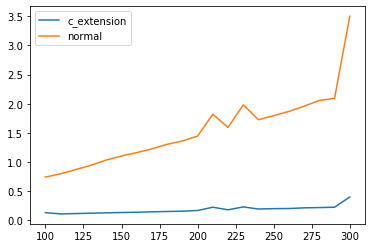

In [41]:
plot_results(results)

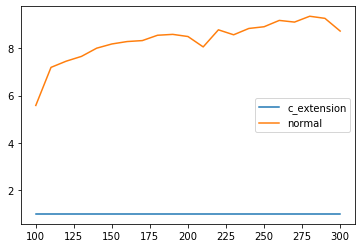

In [42]:
plot_results(results, scale_to=results[0])

In [43]:
results = make_test(range(100, 1100, 100), 4, 1, implementations)

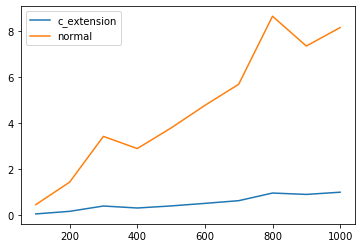

In [44]:
plot_results(results)

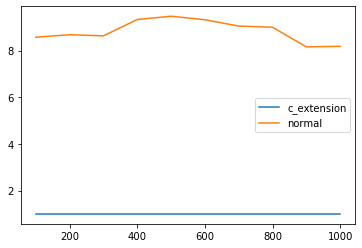

In [45]:
plot_results(results, scale_to=results[0])

It seems the c extension and the numpy implementation are similar in runtime, differing by ~10x, whereas the other implementations scale less well.